In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N =",N,"  L=D=",D)
x=data

N = 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

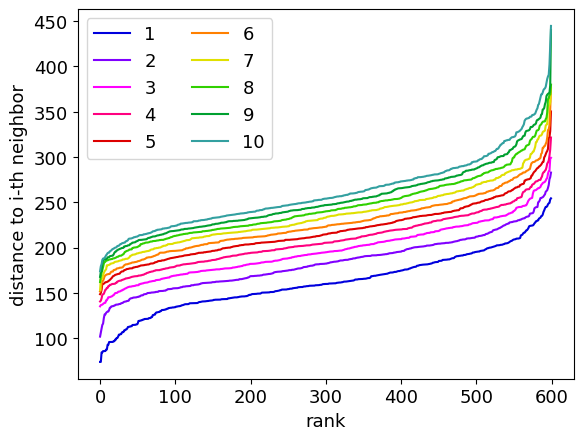

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

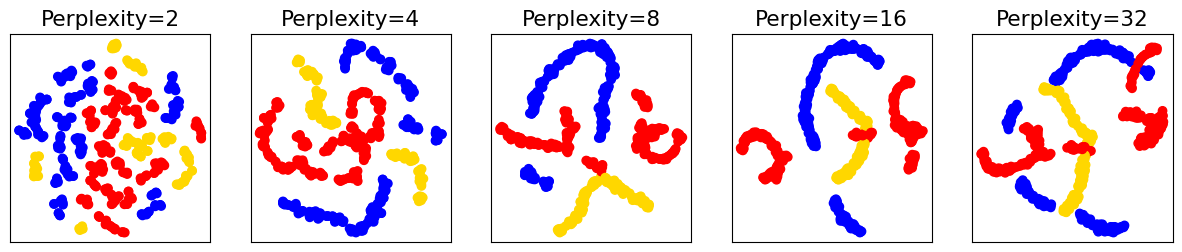

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

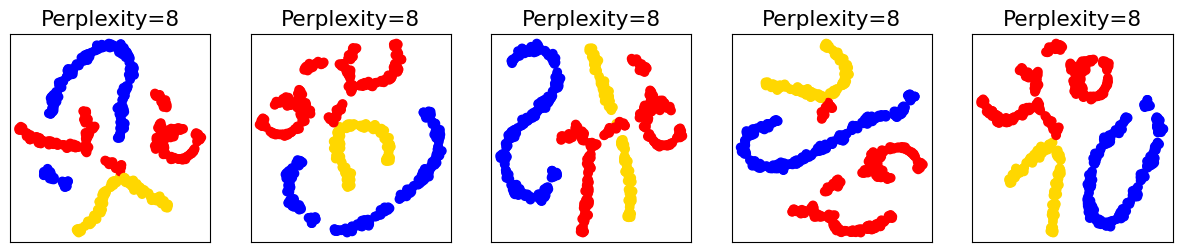

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

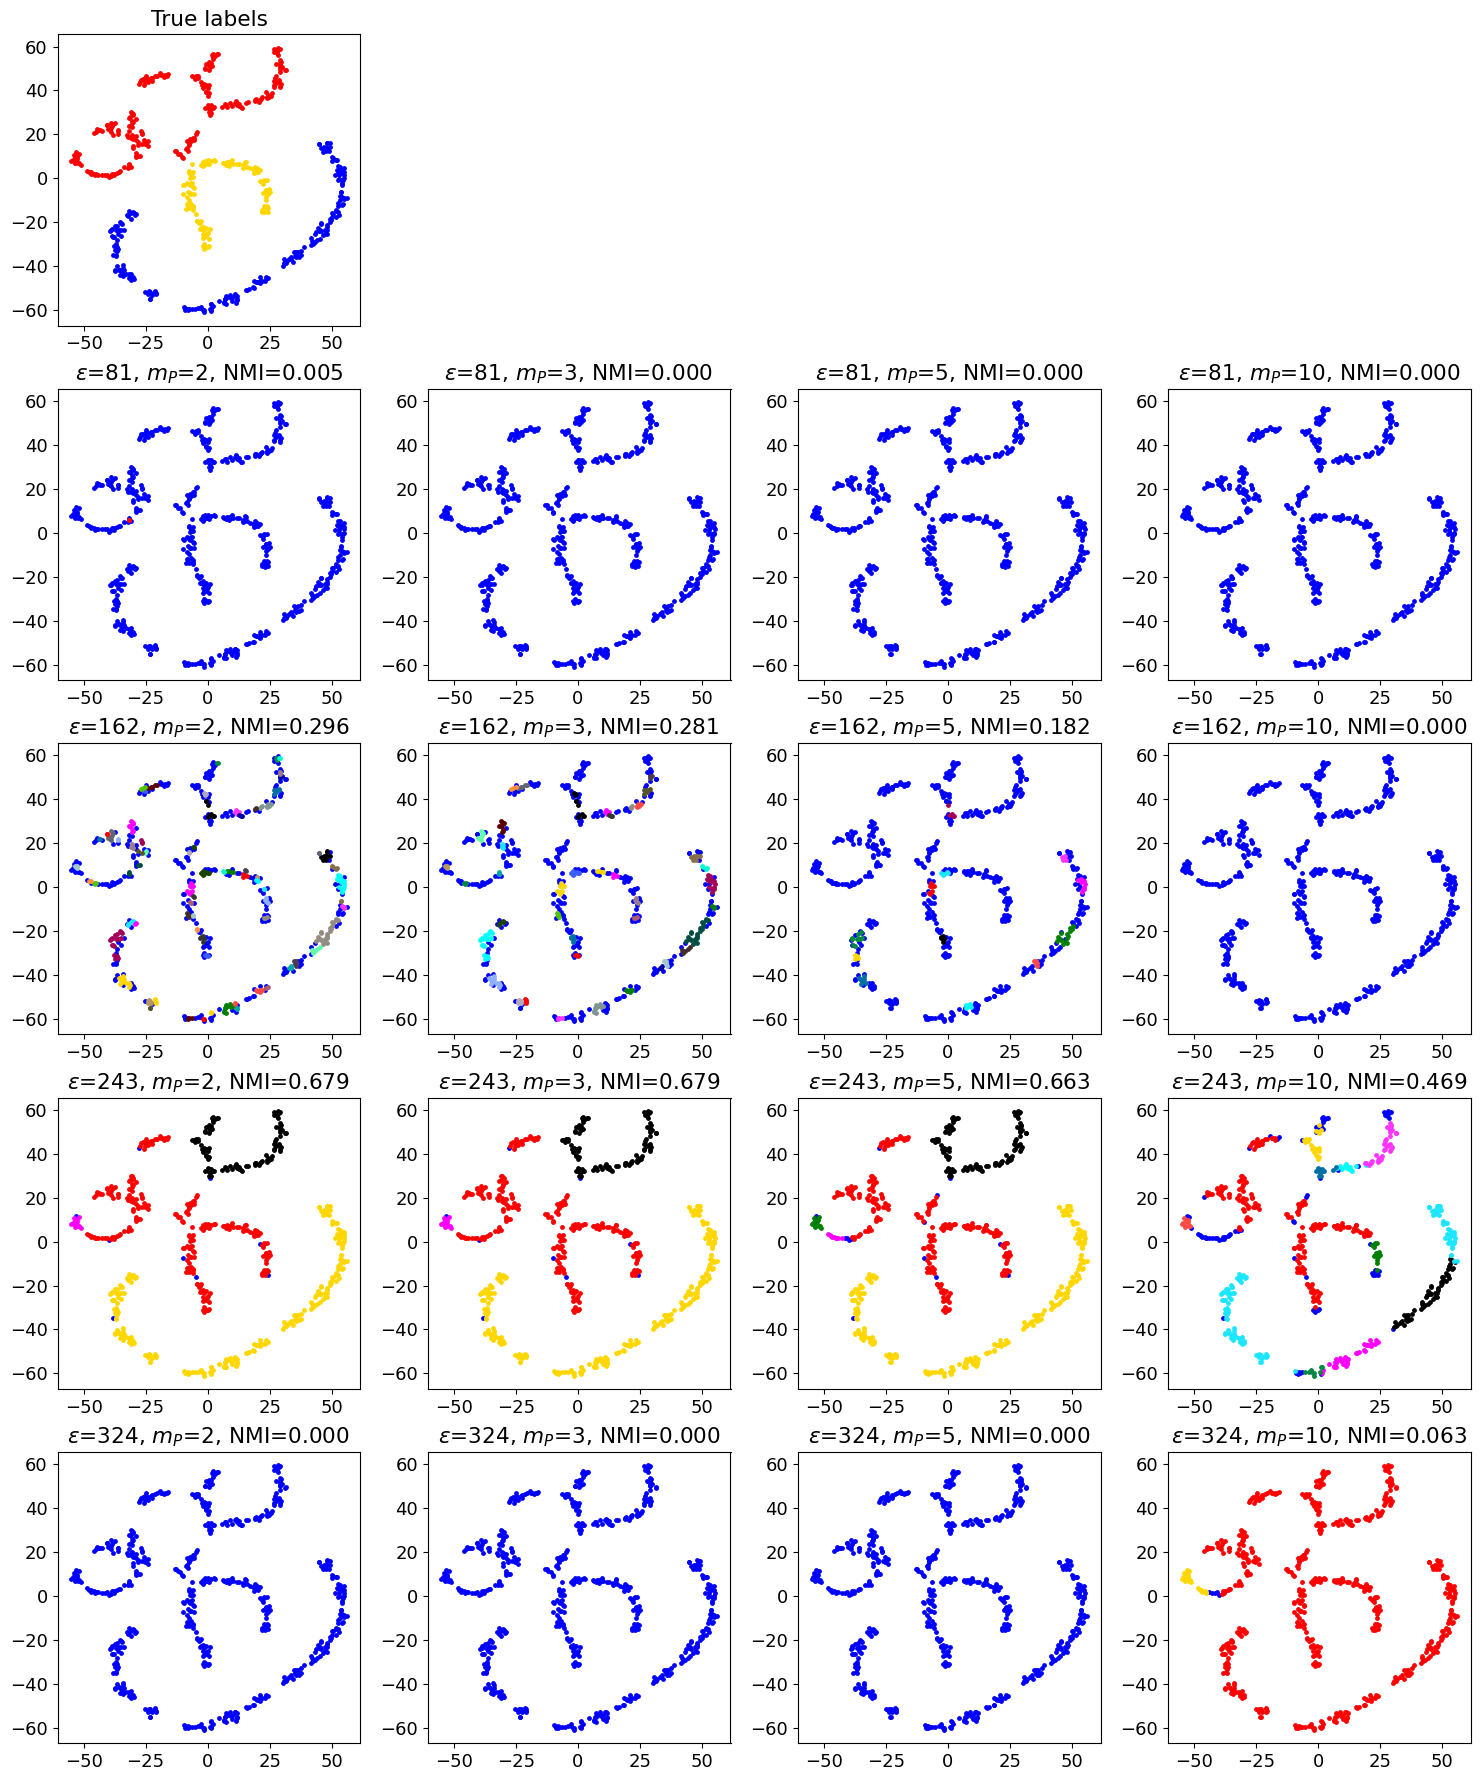

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


### Section 1

In [7]:
import seaborn as sns
eps_range = np.arange(10, 500, 10)
min_sample_range = np.arange(1,50,1)
list_NMI = []

for eps in eps_range:
    for min_samples in min_sample_range:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(data)
        y_hat = model.labels_
        list_NMI.append(NMI(y_hat, y_true))

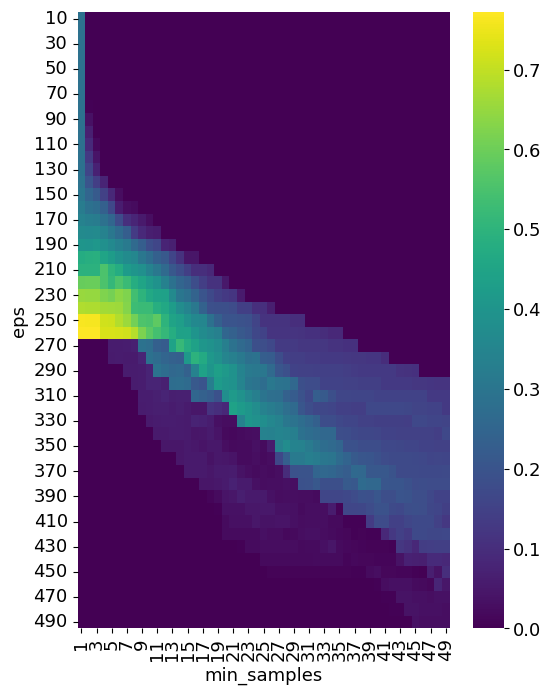

In [8]:
import pandas as pd
NMIs = pd.DataFrame(np.array(list_NMI).reshape(np.shape(eps_range)[0], np.shape(min_sample_range)[0]), index=eps_range, columns=min_sample_range)

fig = plt.figure(figsize=(6, 8))
sns.heatmap(NMIs, cmap='viridis', xticklabels=2, yticklabels=2)
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

### Section 2

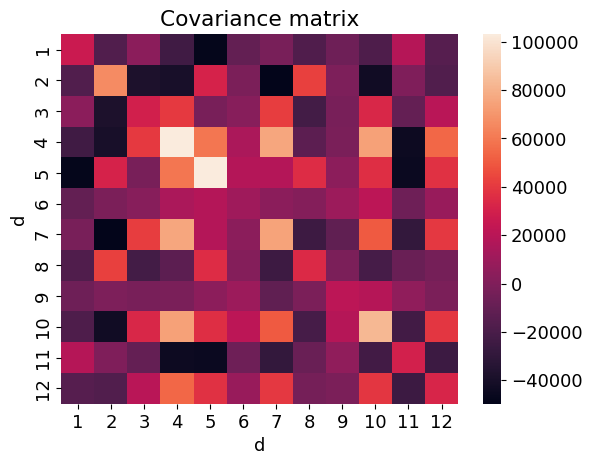

In [10]:
PCA_array = np.array(data)
covariance_matrix = np.cov(PCA_array.T)
C = pd.DataFrame(covariance_matrix, index=np.arange(1,13,1), columns=np.arange(1,13,1))
sns.heatmap(C)
plt.xlabel('d')
plt.ylabel('d')
plt.title('Covariance matrix')
plt.show()

In [11]:
l, V = la.eig(covariance_matrix)

print('Eigenvalues array', l)

Eigenvalues array [344403.2806254  189829.44497039  56998.8773819    3131.76721994
   1966.73023356   2979.05958956   2141.52552016   2247.37039766
   2408.01183302   2730.50913183   2571.56464435   2654.36782084]


In [12]:
i = l.argsort()[::-1]  # reordering from the smallest to the largest eigenvalue
V = V[:, i]

# Normalizing the eigenvalues
normalized_l = l / np.sum(l)
somma = np.sum(l)
frac_x1, frac_x2, frac_x3 = l[0]/somma * 100 , l[1]/somma * 100 , l[2]/somma * 100

print('------------ Percentage contribution of different eigenvalues to the variance: ------------')
print(" l1: %.2f" % frac_x1, '% \n', "l2: %.2f" % frac_x2, '% \n', "l3: %.2f" % frac_x3, '%')
print(f'Total variability explained by the first 3 PCs: {frac_x1 + frac_x2 + frac_x3 :.2f}', '%')

------------ Percentage contribution of different eigenvalues to the variance: ------------
 l1: 56.09 % 
 l2: 30.91 % 
 l3: 9.28 %
Total variability explained by the first 3 PCs: 96.28 %


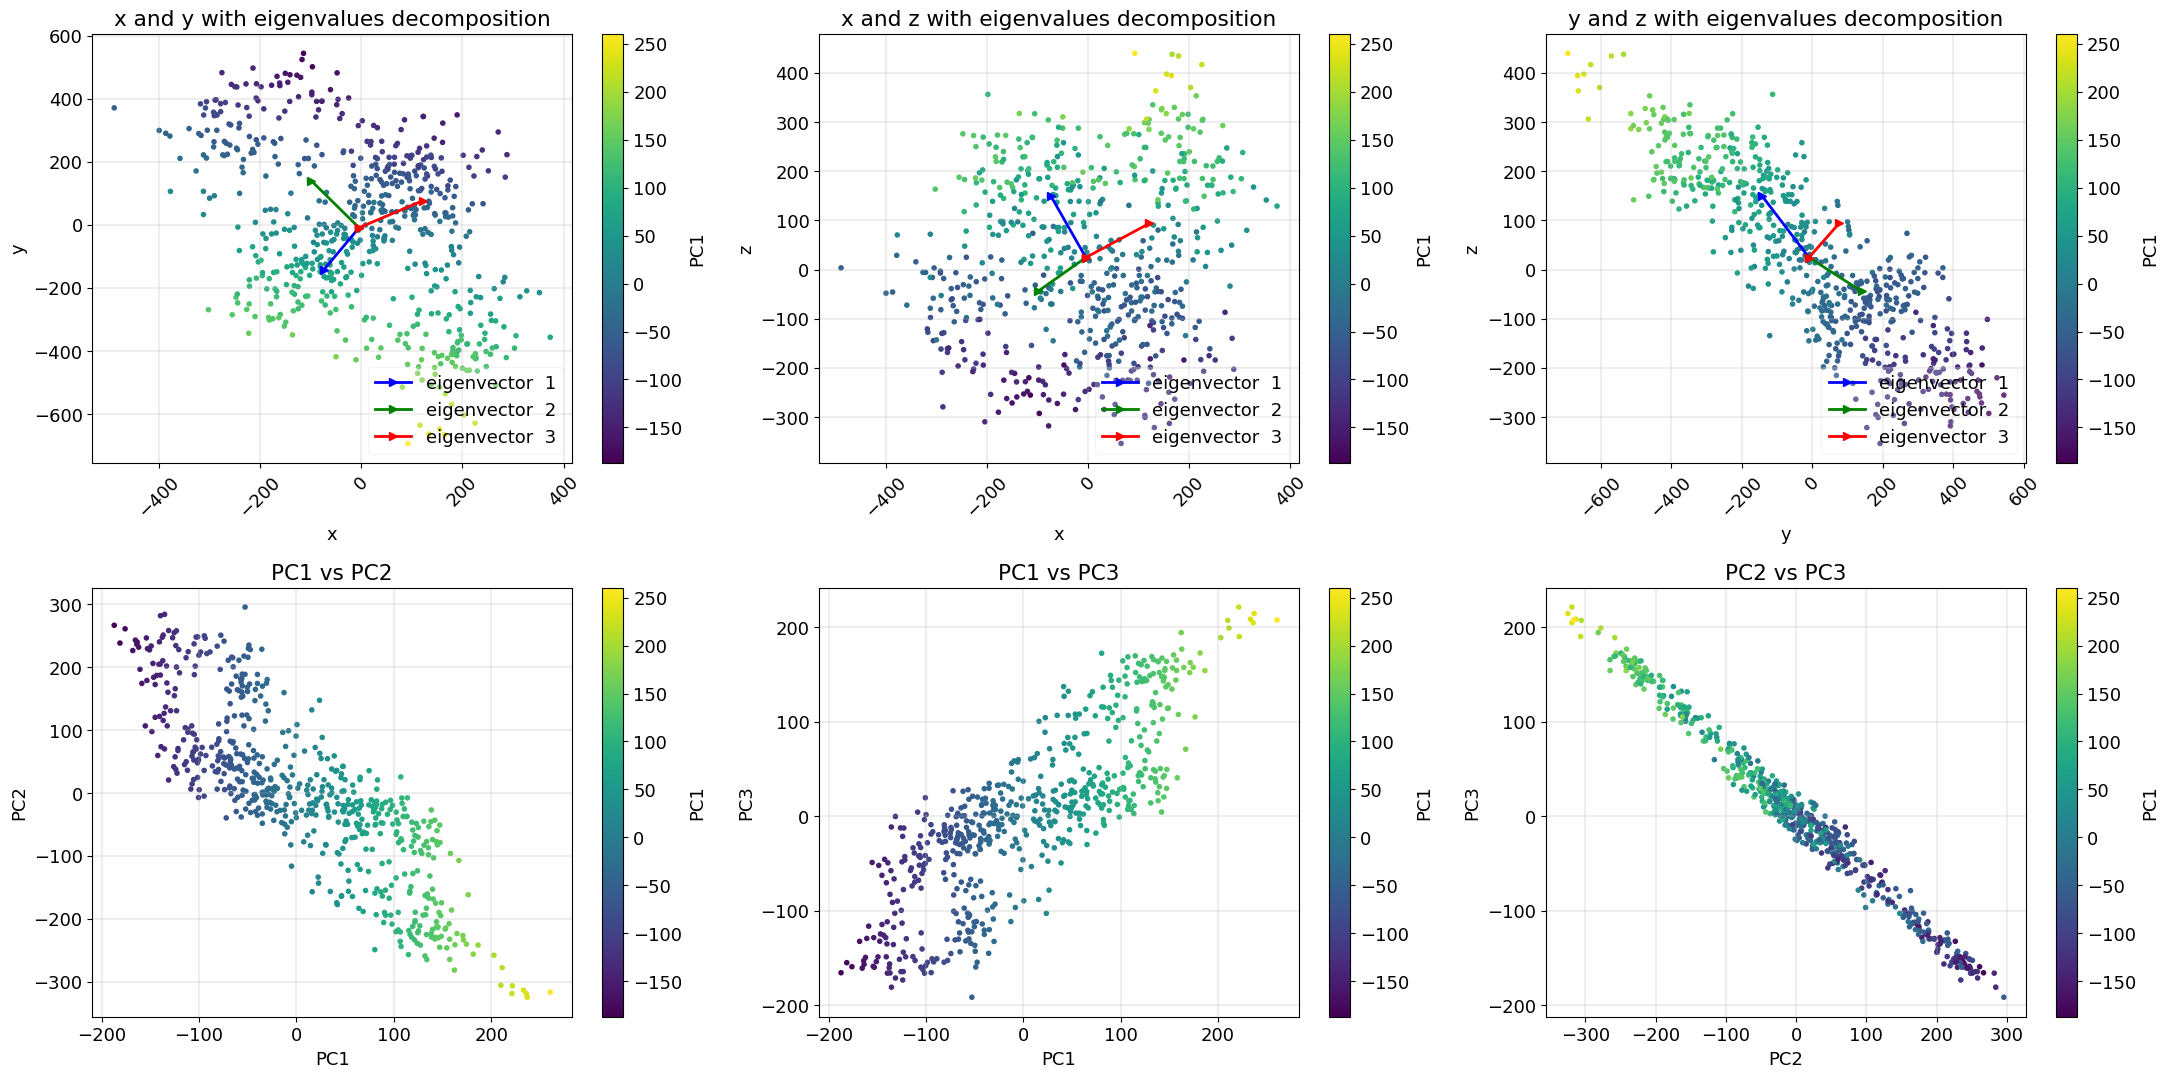

In [38]:
from matplotlib.cm import ScalarMappable
x1, x2, x3 = PCA_array[:, 0], PCA_array[:, 1], PCA_array[:, 2]
# Setting the starting coordinates for the eigenvector plotting
mean_x1 = np.mean(x1)
mean_x2 = np.mean(x2)
mean_x3 = np.mean(x3)


scale_factor = [1000,1000,10000]
colors = ['blue', 'green', 'red']
Xp = np.dot(V[:,:3], [x1, x2, x3])
Xp = np.vstack((Xp, np.zeros(Xp.shape[1])))

plt.figure(figsize=(22,16))

### PLOT 1 ###

plt.subplot(331)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x1, x2, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V.T, scale_factor, colors):
    plt.plot([mean_x1, si*li*vi[0]+mean_x1], [mean_x2, si*li*vi[1]+mean_x2], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter))
    counter += 1

plt.title('x and y with eigenvalues decomposition')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 2 ###

plt.subplot(332)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x1, x3, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V.T, scale_factor, colors):
    plt.plot([mean_x1, si*li*vi[0]+mean_x1], [mean_x3, si*li*vi[2]+mean_x3], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter)) #proiezione degli autovettori nel piano (x, z)
    counter += 1

plt.title('x and z with eigenvalues decomposition')
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 3 ###

plt.subplot(333)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x2, x3, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V.T, scale_factor, colors):
    plt.plot([mean_x2, si*li*vi[1]+mean_x2], [mean_x3, si*li*vi[2]+mean_x3], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter)) #proiezione degli autovettori nel piano (y, z)
    counter += 1

plt.title('y and z with eigenvalues decomposition')
plt.xlabel('y')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 4 ###

plt.subplot(334)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[0,:], Xp[1,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

plt.title('PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linewidth=0.3)

### PLOT 5 ###

plt.subplot(335)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[0,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')
plt.title('PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

### PLOT 6 ###

plt.subplot(336)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[1,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')
plt.title('PC2 vs PC3')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

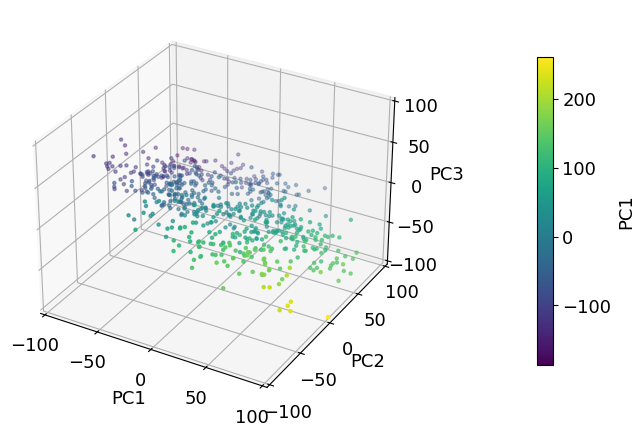

In [66]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.scatter(Xp[0,:], Xp[1,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.5, pad=0.2)
cbar.set_label('PC1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)

plt.show()

### Section 3

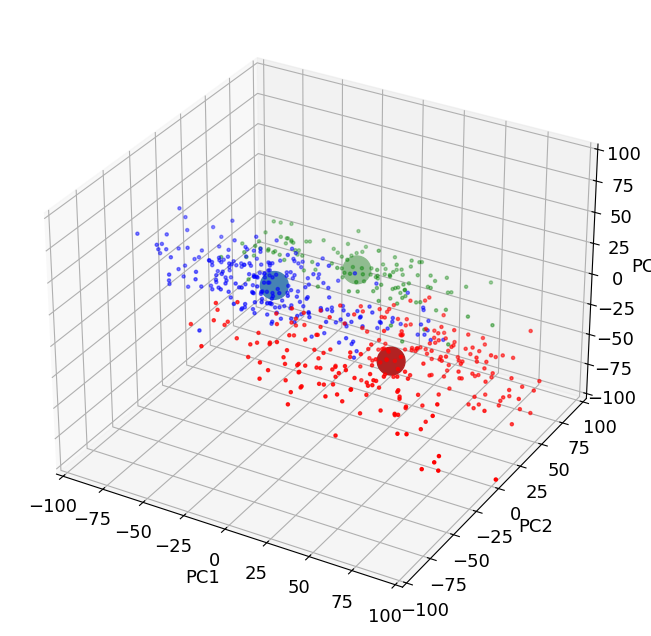

In [85]:
from sklearn import metrics
from sklearn.cluster import KMeans

k=3

kmeans = KMeans(n_clusters=k, init='random', n_init='auto', max_iter=50)
kfit = kmeans.fit(Xp.T)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kcentroids_colors = ['firebrick', 'darkseagreen', 'steelblue']
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('green')
    elif k == 2:
        kclusters_colors.append('blue')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.scatter(Xp[0,:], Xp[1,:], Xp[2,:], marker = '.', color = kclusters_colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)

kcentroids = kcentroids[:3, :3]
#print(kcentroids)
ax.scatter(kcentroids[:, 0], kcentroids[:,1], kcentroids[:,2], s = 400, zorder=10, color = kcentroids_colors, alpha = 1)

plt.show()


### Section 4 (optional)